## ДЗ

Необходимо:
1) Рассмотреть как выглядят данные до и после удаления выбросов, проанализировать как могут выбросы влиять на данные и совместные распределения
2) В данных еще есть выбросы нужно их найти и избавиться от них (либо попробовать использовать)
3) Придумать новые признаки (возраст здания и т.п. для дальнейшего обучения модели)
4) Создать эти признаки для тестовой выборки на основе трейновой
5) Обучить на этих данных модель сравнить с качеством бейзлайна
6) Подобрать параметры и оценить насколько удалось улучшить качество за счет подбора параметров

### Описание данных

 - date: Date house was sold (Дата продажи участка)
 - price: Price of the sold house (Цена продажи)
 - bedrooms: Number of Bedrooms (Число спален)
 - bathrooms: Number of bathrooms (Число ванных комнат)
 - sqft_living: Square footage of the living space (жилая площадь)
 - sqrt_lot: Square footage of the lot (общая площадь)
 - floors: Total floors in the house (кол-во этажей в доме)
 - waterfront: Whether the house is on a waterfront(1: yes, 0: no) (дом на набережной?)
 - view: special view? (вид из окна)
 - condition: Condition of the house (Состояние здания)
 - grade: unknown sqft_above: Square footage of house apart from basement (Площадь здания без подвала)
 - sqft_basement: Square footage of the basement (Площадь подвала)
 - yr_built: Built year (Год постройки)
 - yr_renovated: Year when the house was renovated (Год реновации)
 - zipcode: zipcode of the house (Индекс здания)
 - lat: Latitude coordinate (Широта)
 - long Longitude coordinate (Долгота)
 - sqft_living15: Living room area in 2015(implies some renovations) (после реновации)
 - sqrt_lot15: Lot area in 2015(implies some renovations) (после реновации)

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns

import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from catboost import CatBoostRegressor

# немного экспериментальной магии от sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [3]:
data = pd.read_csv('train.csv')

CONTINUES_COLS = [
    "price",
    "sqft_living",
    "sqft_lot",
    "sqft_above",
    "sqft_living15",
    "sqft_lot15"
]

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15129 entries, 0 to 15128
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15129 non-null  int64  
 1   date           15129 non-null  object 
 2   price          13763 non-null  float64
 3   bedrooms       13615 non-null  float64
 4   bathrooms      13616 non-null  float64
 5   sqft_living    13618 non-null  float64
 6   sqft_lot       13618 non-null  float64
 7   floors         14683 non-null  float64
 8   waterfront     14677 non-null  float64
 9   view           14695 non-null  float64
 10  condition      14656 non-null  float64
 11  grade          14666 non-null  float64
 12  sqft_above     13569 non-null  float64
 13  sqft_basement  14662 non-null  float64
 14  yr_built       14679 non-null  float64
 15  yr_renovated   14677 non-null  float64
 16  zipcode        14692 non-null  float64
 17  lat            14682 non-null  float64
 18  long  

### Задание 1 и 2. Избавимся от выбросов и рассмотрим как выглядят данные до и после удаления выбросов, проанализировать как могут выбросы влиять на данные и совместные распределения

Посмотрим какие у нас еще остались возможные выбросы и аномалии

In [4]:
(data["sqft_basement"] / data["sqft_lot"])\
    .value_counts()\
    .reset_index()\
    .sort_values(by='index', ascending=False)\
    .rename({'index':'basement_area_increase', 0:'count'}, axis=1)\
    .query('basement_area_increase > 0.3')

,basement_area_increase,count
566,0.737179,1
4171,0.627208,1
351,0.600000,2
930,0.592075,1
792,0.574468,1
...,...,...
44,0.303030,4
2112,0.302778,1
512,0.302362,1
2552,0.301612,1


Есть ряд объектов, где площадь подвала больше общей площади объекта более чем на 30%. А есть объекты, где даже более чем на 60%. Выбросы? Аномалии? Я бы уточнил у поставщика данных. А пока не будем считать это каким-то выбросом и удалять их не будем.

In [ ]:
(data["sqft_lot15"] / data["sqft_lot"])\
    .value_counts()\
    .reset_index()\
    .sort_values(by='index', ascending=False)\
    .rename({'index':'lot_area_increase', 0:'count'}, axis=1)\
    .query('lot_area_increase > 2')

Вот так реновация! В ряде случаев общая площадь увеличилась более чем в 2 раза, а где-то и почти в 34! Этот вопрос я бы также уточнил у поставщика. Пока не удаляем.

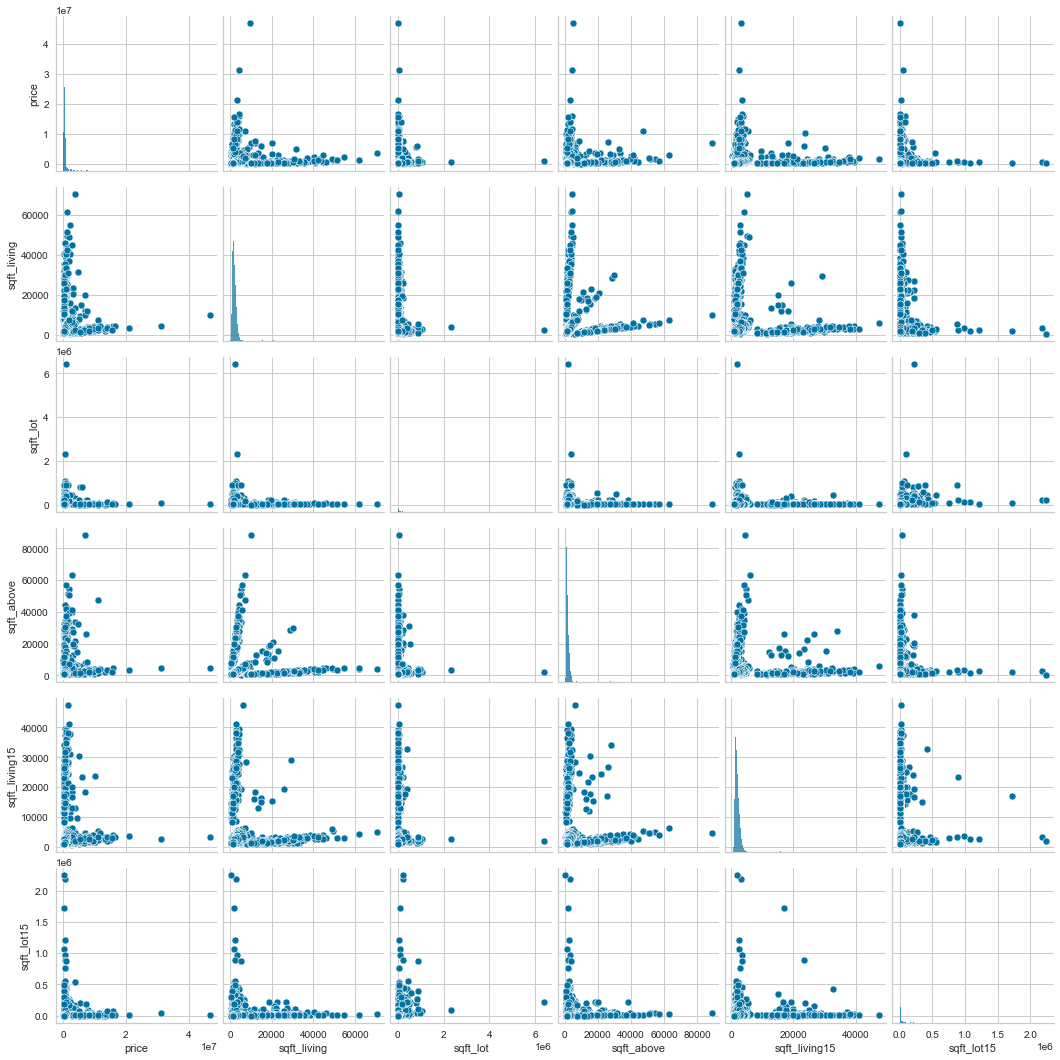

In [6]:
sns.pairplot(data[CONTINUES_COLS])

In [ ]:
for col in CONTINUES_COLS:
    high_quantile = 0.95
    filtered_count = len(data[data[col] > data[col].quantile(high_quantile)])
    len_data = len(data)
    # отфильртуем все, что больше 0,95 квантиля
    print(f"В колонке {col} отфильтруем {filtered_count} значений, что составляет {filtered_count / len_data:.02f}% от датасета")
    data[col] = data[data[col] < data[col].quantile(high_quantile)][col]

In [ ]:
sns.pairplot(data[CONTINUES_COLS])

### Выводы

После того как мы избавились от выбросов, наши данные приобрели "объем" при построении графиков совместных распределений и теперь можно более наглядно разглядеть или оценить зависимости.

### Задание 3, 4 и 5. Придумаем новые признаки (возраст здания и т.п. для дальнейшего обучения модели) и обучим модель из бейзлайна на полученном датасете

Для начала избавимся от пропусков

# посмотрим сколько у нас пропусков и где

In [ ]:
data.isna().sum()

У нас много пропусков в достаточно важных (на первый взгляд) метриках и в целевой метрике. Заполнять пропуски в целевой метрике имхо не самая удачная идея т.к. модель на этих данных будет учиться, а заполняем мы с довольно высоким риском (а скорее всего и долей) ошибки. Поэтому удалим пропуски в целевой метрике и посмотрим что останется.

In [ ]:
data = data.dropna(subset=['price'])
data.isna().sum()

Поля ID и DATE для дальнейшего обучения модели бесполезны - удалим их.
Также мы не сможем восстановить пропуски в координатах (поля long и lat), а они нам будут нужны в дальнейшем для обучения - поэтому удалим записи с пропусками в этих значениях.
Также не забываем проверять сколько данных будет удалено :) В нашем случае около 700 записей, что ок.

In [ ]:
data = data.drop(['id', 'date'], axis=1)
data = data.dropna(subset=['long', 'lat'])

Посмотрим сколько пропусков осталось

In [ ]:
data.isna().sum()

Заполним пропуски с помощью случайного леса с дефолтными параметрами

In [ ]:
impute_model = CatBoostRegressor(thread_count=-1, random_state=25)
# ограничим количество итераций до 3 (чтобы на моем компе это выполнялось за разумное время :D, но чутка ухудшив качество дефолтно - 10)
# и заполнять будем от поля с наибольшим количеством пропусков к меньшему
it_imputer = IterativeImputer(impute_model, max_iter=3, imputation_order='descending')
data_after_imputer = it_imputer.fit_transform(data)

Отлично, теперь преобразуем восстановленные данные обратно в DataFrame и проверим, остались ли пропуски


In [ ]:
data_after_imputer = pd.DataFrame(data_after_imputer, index=data.index, columns=data.columns)
data_after_imputer.isna().sum()

От пропусков избавились, теперь добавим новые признаки

Кластеризуем объекты по координатам Посмотрим как сейчас располагаются наши объекты

In [ ]:
x_axis = data_after_imputer['long']
y_axis = data_after_imputer['lat']

fig = px.scatter(
    x=x_axis,
    y=y_axis,
    title='Расположение объектов по координатам'
    )

fig.update_xaxes(
    title='Долгота'
)
fig.update_yaxes(
    title='Широта'
)

fig.show()

Видим несколько явных кластеров, некоторые явно очень отдаленные объекты и большие кучи данных) Попробуем это разобрать по кластерам с помощью KMeans. Для начала определим оптимальное количество кластеров для KMeans elbow методом.

In [ ]:
kmean = KMeans()
visualiser = KElbowVisualizer(kmean, k=(2, 30))
visualiser.fit(data_after_imputer[['long', 'lat']])
visualiser.show()

In [ ]:
visualiser.elbow_value_

Оптимально разделить выборку по координатам на 8 кластеров. Сделаем это и посмотрим что получится.

In [ ]:
kmean_classifier = make_pipeline(StandardScaler(), KMeans(n_clusters=8))
pred = kmean_classifier.fit_predict(data_after_imputer[['long', 'lat', 'price']])

fig = px.scatter(
    x=x_axis,
    y=y_axis,
    color=pred,
    title='Расположение объектов по координатам после классификации с помощью KMeans'
    )

fig.update_xaxes(
    title='Долгота'
)
fig.update_yaxes(
    title='Широта'
)

fig.show()

Также посмотрим как данная классификация влияет на целевой признак и посмотрим, действительно ли там есть разница между классами

In [ ]:
fig = px.box(
    x=pred,
    y=data_after_imputer['price'],
    title='Боксы цен по классам из KMeans')

fig.update_xaxes(
    title='Классы, полученные с помощью KMeans'
)

fig.update_yaxes(
    title='Цены'
)

fig.show()

Медианы цен почти во всех классах довольно сильно отличаются, есть вопросы к 1 и 3 классу, они выглядят довольно похожими. Но пока оставим как есть. Приаттачим полученные классы к датасету и разобъем его на обучающую и тестовую выборки.

In [ ]:
# присоединяем классы к датасету
data_after_imputer['geo_class'] = pred
# отделяем фичи от таргета
features = data_after_imputer.drop('price', axis=1)
target = data_after_imputer['price']
# разделяем выборки
X, X_test, y, y_test = train_test_split(features, target, test_size=.25, random_state=25)

Повторим шаги из бейзлайна

In [ ]:
lr = make_pipeline(StandardScaler(), LinearRegression())
lr.fit(X, y)
print(r2_score(y_test, lr.predict(X_test)))

In [ ]:
feat_importances = pd.Series(lr[1].coef_, index=X.columns).sort_values(ascending=False)
fig = px.bar(feat_importances, title='Наиболее значимые признаки для линейной регрессии')

fig.update_layout(
    showlegend=False
)

fig.update_xaxes(
    title='Признак'
)

fig.update_yaxes(
    title='Коэфициент важности'
)

fig.show()

Ого! После очистки от выбросов и введения одного нового признака модель дает R2 = 0.71, при дефолтном бейслайне R2 = 0.11. Как ни странно, но общая площадь, количество спален и ванных комнат линейной регрессии вообще не важно. Что логично, она же не человек :) Попробуем модель CatBoostRegressor для решения этой задачи и подберем для нее параметры.

In [ ]:
cbr = CatBoostRegressor(thread_count=-1, random_state=25)

params = dict(
    depth=[3, 5, 6, 8, 10],
    nan_mode=['Min', 'Max'],
    n_estimators=[100, 500, 1000, 1500, 2000]
)

cbr.randomized_search(params, X, y, cv=3, n_iter=10)

In [ ]:
print(r2_score(y_test, cbr.predict(X_test)))

Целевая метрика улучшилась еще на 18 пунктов. Catboost знает свое дело :)


In [ ]:
feat_importances = pd.Series(cbr.feature_importances_, index=X.columns).sort_values(ascending=False)

fig = px.bar(feat_importances, title='Наиболее значимые признаки для CatBoostRegressor')

fig.update_layout(
    showlegend=False
)

fig.update_xaxes(
    title='Признак'
)

fig.update_yaxes(
    title='Значение'
)

fig.show()

Наш целевой признак где-то по-середине, что тоже не плохо :)

Теперь отберем самые важные признаки для модели CBR и попробуем обучиться только на них. Посмотрим как это влияет на метрику. Отберем 6 самых важных признаков.

In [ ]:
best_features = feat_importances.nlargest(6).index
X_best_features = X[best_features]
X_test_best_features = X_test[best_features]

In [ ]:
cbr = CatBoostRegressor(thread_count=-1, random_state=25)

params = dict(
    depth=[3, 5, 6, 8, 10],
    nan_mode=['Min', 'Max'],
    n_estimators=[100, 500, 1000, 1500, 2000]
)

cbr.randomized_search(params, X_best_features, y, cv=3, n_iter=10)

Из-за меньшего количества фич, обучение проходит гораздо быстрее. Сейчас посмотрим на качество.

In [ ]:
print(r2_score(y_test, cbr.predict(X_test_best_features)))

В нашем случае качество ухудшилось на 3 пункта после выделения важных признаков. Но попробуем все таки добиться аналогичного качества модели, при сокращении вычислительных мощностей для обучения путем отброса самых незначительных признаков. Отбросим 4 самых незначительных признака. И оценим модель.

In [ ]:
features_without_worst = feat_importances[:len(feat_importances)-4].index
X_without_worst = X[features_without_worst]
X_test_without_worst = X_test[features_without_worst]

cbr = CatBoostRegressor(thread_count=-1, random_state=25)

params = dict(
    depth=[3, 5, 6, 8, 10],
    nan_mode=['Min', 'Max'],
    n_estimators=[100, 500, 1000, 1500, 2000]
)

cbr.randomized_search(params, X_without_worst, y, cv=3, n_iter=10)

In [ ]:
print(r2_score(y_test, cbr.predict(X_test_without_worst)))

Чутка сэкономили вычислительные мощности, а также для этой модели можно не собирать целых 4 признака, а это может избавить всю систему в целом от нескольких процессов по сбору этих признаков в принципе, и как следствие меньше нужно объемов для хранения данных, меньше дебагов, работы и головных болей :)

In [ ]:
from sklearn.ensemble import IsolationForest

i_model = IsolationForest()
i_model.fit(data_after_imputer)
i_pred = i_model.predict(data_after_imputer)

In [ ]:
i_pred = pd.Series(i_pred, index=data_after_imputer.index)
isolated = data_after_imputer.drop(i_pred[i_pred < 0].index)

In [ ]:
sns.pairplot(isolated[CONTINUES_COLS])

In [ ]:
px.scatter_matrix(data[CONTINUES_COLS], color='price')

In [ ]:
px.scatter_matrix(isolated[CONTINUES_COLS], color='price')

In [ ]:
# вспомним что за данные у нас вообще есть
data.head()